# import

In [1]:
import torch
import pandas as pd
from glob import glob
import os

from torch.utils.data.dataset import Dataset
import cv2
from PIL import Image
import PIL
import numpy as np
from albumentations.pytorch import transforms
import albumentations as A
import timm
import matplotlib.pyplot as plt
import torchsummary
from tqdm import tqdm
import logging

from models.vggnet import VGGNet
from models.googlenet import GoogleNet
from models.resnet import ResNet
from models.densenet import DenseNet

In [2]:
# read
base_path = '../../datasets/mnist'
num = glob(f'{base_path}/training/*')
# for i, n in enumerate(num):
#     print(n)


imgs = list()
labels = list()

for direc in glob(f'{base_path}/training/*'):
    for p in glob(f'{direc}/*'):
        num = p.split('/')[-2]
        imgs.append(p)
        labels.append(num)

In [3]:
df = pd.DataFrame()
df['img_path'] = imgs
df['label'] = labels

In [4]:
class Mnist(Dataset):
    def __init__(self, df, transforms=None):
        self.data = df
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data.iloc[idx]
        img = np.array(Image.open(path))
        img = np.expand_dims(img, -1)
        img = np.concatenate([img, img, img], axis=-1)
        img = self.transforms(image=img) if self.transforms else img
        label = int(label)
        
        return img, label 

In [5]:
transform = A.Compose(
    [
        A.Resize(112, 112),
        A.Normalize(mean=0.5, std=0.5),
        transforms.ToTensorV2()
    ]
)

In [6]:
ds = Mnist(df, transform)
loader = torch.utils.data.DataLoader(ds, batch_size=16, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


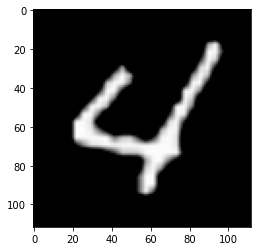

In [7]:
img, label = ds.__getitem__(1)
plt.imshow(np.transpose(img['image'], (1, 2, 0)), cmap='gray')

In [8]:
model = DenseNet()
criterion = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=.01)

In [9]:
for epoch in range(10):
    import os
    os.remove('train.log')
    logger = logging.Logger('train')
    handler = logging.FileHandler('train.log')
    logger.addHandler(handler)

    model.train()
    model.to('cuda:0')

    ep_loss = 0
    ep_acc = 0
    step = 0
    for data in tqdm(loader):
        step += 1

        img, label = data
        img = img['image'].type(torch.float32)
        img = img.to('cuda:0')
        label = torch.tensor(label, dtype=torch.float32).to('cuda:0')
        pred = model(img)
        pred = pred.type(torch.float32)
        pred.requires_grad_(True)

        loss = criterion(pred, label.type(torch.int64))
        optim.zero_grad()
        loss.backward()
        optim.step()

        ep_loss += loss
        
        m = pred.detach().cpu().max(1, keepdim=True)[1]
        acc = m.eq(label.cpu().data.view_as(m)).sum()
        ep_acc += acc

        # if step == 8:
        #     optim.step()
        #     optim.zero_grad()
        #     step = 0
        logger.info(f'acc: {acc / len(data)},  loss: {loss}')

    print('loss: ', ep_loss / len(loader.dataset))
    print('acc: ', ep_acc / len(loader.dataset))
        

  0%|          | 0/3750 [00:00<?, ?it/s]/tmp/ipykernel_714/2327781025.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32).to('cuda:0')
100%|██████████| 3750/3750 [20:42<00:00,  3.02it/s]


loss:  tensor(0.0426, device='cuda:0', grad_fn=<DivBackward0>)
acc:  tensor(0.7709)


100%|██████████| 3750/3750 [21:02<00:00,  2.97it/s]


loss:  tensor(0.0147, device='cuda:0', grad_fn=<DivBackward0>)
acc:  tensor(0.9305)


100%|██████████| 3750/3750 [20:25<00:00,  3.06it/s]


loss:  tensor(0.0116, device='cuda:0', grad_fn=<DivBackward0>)
acc:  tensor(0.9458)


100%|██████████| 3750/3750 [20:30<00:00,  3.05it/s]


loss:  tensor(0.0098, device='cuda:0', grad_fn=<DivBackward0>)
acc:  tensor(0.9535)


 29%|██▉       | 1092/3750 [05:55<14:24,  3.07it/s]


KeyboardInterrupt: 